# TensorFlow

In [399]:
import tensorflow as tf
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)

#### Constants

In [266]:
x = tf.constant([1,2,3])
y = tf.Variable(x+5) # defining ```y=x+5``` is the same.
hello = tf.constant('Hello, TensorFlow!')

# we use the `with` statement so that the session closes automatically at the end of the with block.
# we need to close the session in order to release assigned resources.
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    #i can do ```session.run()``` or ```variable.eval()```
    print(session.run(y))
    print(hello.eval())
    print(session.run(hello))
    

[6 7 8]
b'Hello, TensorFlow!'
b'Hello, TensorFlow!'


#### I can update tensorflow variables in loops

In [16]:
x = tf.Variable(initial_value=0, dtype=tf.int64)

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for i in range(3):
        x += 1
        print(session.run(x))
        print(x.eval())

1
1
2
2
3
3


#### Linear equation solver

In [30]:
#point 1
x1 = tf.constant(value=1., dtype=tf.float32)
y1 = tf.constant(value=2., dtype=tf.float32)

#point 2
x2 = tf.constant(value=0., dtype=tf.float32)
y2 = tf.constant(value=-1., dtype=tf.float32)

#im using tf.pack to create the tensor
points = tf.transpose(tf.pack([[x1,y1], [x2,y2]]))
ones = tf.ones((1,2))
params = tf.matmul(ones, tf.matrix_inverse(points))

with tf.Session() as session:
#     print(points.eval())
#     print(ones.eval())
    result = session.run(params)
    a = result[0][0]
    b = result[0][1]
    print("Equation: y = {a}x + {b}".format(a=a, b=b))

Equation: y = 3.0x + -1.0


#### Saving and restoring variables

Tensorflow does not save the model, only (the specified) variables. This means that when we restore the model, the computational graph must be the same as when we performed the save operation.

Some people make a unique workflow where they include the graph creation, the saving and restoring of the params and then put a flag to distinguish between training and prediction.

I can otherwise use the `tf.get_variables()` method for initializing/retrieving variables.

#### A function approximator

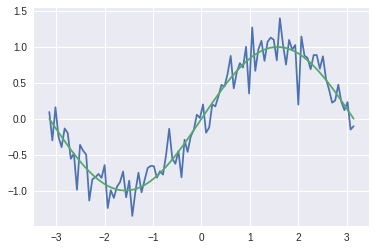

In [400]:
x_train = np.linspace(-1*np.pi, 1*np.pi, 100)
y_sin = np.sin(x_train)
y_train = np.random.normal(y_sin, scale=0.2)

plt.plot(x_train,y_train)
plt.plot(x_train,y_sin)
plt.show()


Nr of minibatches: 13
37.4318974763 73.1736
1.52734538168 50.2178
1.49398556352 49.8308
1.4802442193 49.5119
1.47208783031 49.298
1.46649867296 49.145
1.46234951913 49.0285
1.45910748094 48.9356
1.4564800635 48.859
1.45429325849 48.7943


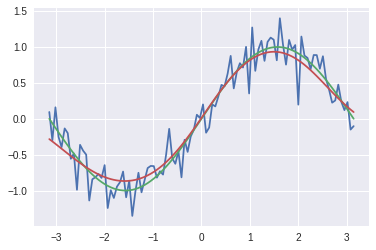

In [402]:
graph = tf.Graph()

minibatch_size = 8

with graph.as_default():
    tf.set_random_seed(1234) # seeds are applied at graph level.
    x = tf.placeholder(dtype=tf.float32, name='x')
    y = tf.placeholder(dtype=tf.float32, name='y')
    
    n_hidden = tf.constant(value=10)

    w1 = tf.Variable(initial_value=tf.random_normal(shape=[1,n_hidden], stddev=.2), name='w1')
    b1 = tf.Variable(initial_value=tf.random_normal(shape=[n_hidden], stddev=.2), name='b1')
    w2 = tf.Variable(initial_value=tf.random_normal(shape=[n_hidden, 1], stddev=.2), name='w2')
    
    hidden_activations1 = tf.tanh(tf.matmul(x,w1)+b1)
    forward_pass = tf.matmul(hidden_activations1, w2)

    l2 = tf.reduce_sum(tf.add(tf.square(w1), tf.square(w2)))
    mse = tf.square(tf.sub(y, forward_pass))

    loss = tf.reduce_mean(tf.add(mse, 0.001*l2))

    train_op = tf.train.AdagradOptimizer(0.8).minimize(loss)

with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    
    n_minibatch = np.int(np.ceil(x_train.shape[0]/np.float(minibatch_size)))
    print('Nr of minibatches: %d' % n_minibatch)
    
    for epoch_ix in range(3000):
        epoch_loss = 0
        for minibatch_ix in range(n_minibatch):
            _, output_loss = session.run([train_op, loss], feed_dict={x: np.matrix(x_train[minibatch_ix*minibatch_size:(minibatch_ix+1)*minibatch_size]).T, y: y_train[minibatch_ix*minibatch_size:(minibatch_ix+1)*minibatch_size]})
            epoch_loss += output_loss
        
        if (epoch_ix%300) == 0:
            print(epoch_loss, l2.eval())
    
    predictions = session.run(forward_pass, feed_dict={x:np.matrix(x_train).T})

    plt.plot(x_train, y_train)
    plt.plot(x_train, y_sin)
    plt.plot(x_train, np.array(predictions).reshape((-1,)))
    plt.show()
        

##### About minibatch sizes:
From: https://www.quora.com/Intuitively-how-does-mini-batch-size-affect-the-performance-of-stochastic-gradient-descent

The two main things to consider when optimizing mini-batch size are the time efficiency of training and the noisiness of the gradient estimate. 

Let's say we have a dataset with 100,000 training examples, and we are considering a mini-batch size of 100 and 10,000. Computing the gradient of a batch generally involves computing some function over each training example in the batch and summing over the functions. In particular, gradient computation is roughly linear in the batch size. So it's going to take about 100x longer to compute the gradient of a 10,000-batch than a 100-batch. 

This means that the 100-batch version of our model is going to make 100 parameter updates in the time it takes the 10,000-batch model to make 1 update. The gradient of the 100-batch isn't going to be quite as accurate as the gradient of a 10,000-batch, so the 100 updates probably won't be 100x as productive as the single update from the larger 10,000-batch. But they might be 10x more productive, which drastically cuts down on total training time.

On to the noisiness part of the equation. When we compute the gradient of a mini-batch, what we're really doing is approximating the gradient of the entire training set. Obviously, the gradient of a single data point is going to be a lot noisier than the gradient of a 100-batch. This means that we won't necessarily be moving down the error function in the direction of steepest descent. 

But noisiness isn't all bad. In particular, suppose that our error function is particularly pernicious and has a bunch of little valleys. If we used the entire training set to compute each gradient, our model would get stuck in the first valley it fell into (since it would register a gradient of 0 at this point). If we use smaller mini-batches, on the other hand, we'll get more noise in our estimate of the gradient. This noise might be enough to push us out of some of the shallow valleys in the error function. 


#### Visualizing the graph
Im gonna add `tf.name_scope()` statements to the previous graph definition so that the visualization is more friendly. And Im gonna make use of some functions for inline plotting (taken from: http://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter)

In [403]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [404]:
graph = tf.Graph()

minibatch_size = 8

with graph.as_default():
    tf.set_random_seed(1234) # seeds are applied at graph level.
    x = tf.placeholder(dtype=tf.float32, name='x')
    y = tf.placeholder(dtype=tf.float32, name='y')
    
    n_hidden = tf.constant(value=10)

    w1 = tf.Variable(initial_value=tf.random_normal(shape=[1,n_hidden], stddev=.2), name='w1')
    b1 = tf.Variable(initial_value=tf.random_normal(shape=[n_hidden], stddev=.2), name='b1')
    w2 = tf.Variable(initial_value=tf.random_normal(shape=[n_hidden, 1], stddev=.2), name='w2')
    
    with tf.name_scope('Forward_pass') as scope:
    
        with tf.name_scope('Layer_1') as scope:
            hidden_activations1 = tf.tanh(tf.matmul(x,w1)+b1)
            
        with tf.name_scope('Layer_2') as scope:
            forward_pass = tf.matmul(hidden_activations1, w2)
        
    with tf.name_scope('Loss_function') as scope:
        
        with tf.name_scope('L2') as scope:
            l2 = tf.reduce_sum(tf.add(tf.square(w1), tf.square(w2)))
            
        with tf.name_scope('MSE') as scope:
            mse = tf.square(tf.sub(y, forward_pass))

        with tf.name_scope('Loss') as scope:
            loss = tf.reduce_mean(tf.add(mse, 0.001*l2))

        with tf.name_scope('Optimizer') as scope:
            train_op = tf.train.AdagradOptimizer(0.8).minimize(loss)

with graph.as_default():
    show_graph(graph.as_graph_def())

#### Modularizing the code
This means, making sure that all tensors and ops belong to the same graph (ie, making sure that we always use the same graph), and sharing tensors across different pieces of code via `tf.variable_scope()` and `tf.get_variable()`.

Nr of minibatches: 13
34.6706689447 81.7402
1.58386291564 53.1285
1.541978769 51.9781
1.48812696338 49.2333
1.47548208386 49.096
1.46883837134 49.0366
1.46410673112 48.9453
1.46044144779 48.8583
1.45748066157 48.7826
1.45502696186 48.7177
[[ -1.59642077e-04   9.40504551e-01  -4.40496691e-02  -1.06317115e-10
   -7.81433642e-01   2.20138390e-05  -2.21711060e-18  -7.81324327e-01
    4.49039250e-25  -7.93227792e-01]]
[ -1.76561158e-03  -2.36656165e+00  -7.63415694e-01  -1.53654778e-09
   4.93006669e-02   3.51989234e-04  -1.17106884e-16   4.94131967e-02
   1.48051159e-23  -2.16923666e+00]
[[  2.04472788e-04]
 [ -8.48343015e-01]
 [  8.84319693e-02]
 [  1.42993867e-10]
 [ -6.67436719e-01]
 [ -2.74901467e-05]
 [  3.44279850e-18]
 [ -6.66595995e-01]
 [ -6.82811178e-25]
 [  7.15590060e-01]]


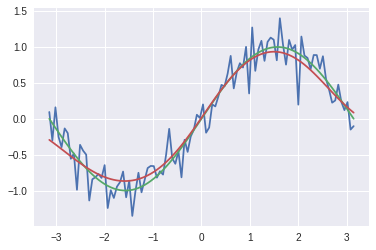

In [406]:
def create_placeholders():
    x = tf.placeholder(dtype=tf.float32, name='x')
    y = tf.placeholder(dtype=tf.float32, name='y')
    
    return x, y

def get_hidden_layer_size():
    return tf.constant(value=10, name='n_hidden')

def get_variables(reuse):
    n_hidden = tf.get_default_graph().get_tensor_by_name('n_hidden:0')
    
    with tf.variable_scope("params", reuse=reuse) as scope:
        w1 = tf.get_variable(initializer=tf.random_normal(shape=[1,n_hidden], stddev=.2), name='w1')
        b1 = tf.get_variable(initializer=tf.random_normal(shape=[n_hidden], stddev=.2), name='b1')
        w2 = tf.get_variable(initializer=tf.random_normal(shape=[n_hidden, 1], stddev=.2), name='w2')
    
    return w1, b1, w2

def compute_forward_pass():
    x = tf.get_default_graph().get_tensor_by_name('x:0')
    n_hidden = tf.get_default_graph().get_tensor_by_name('n_hidden:0')
    
    w1, b1, w2 = get_variables(reuse=True)
    
    hidden_activations1 = tf.tanh(tf.matmul(x, w1) + b1)
    
    return tf.matmul(hidden_activations1, w2)

def compute_l2_regularization():
    w1, _, w2 = get_variables(reuse=True)
    
    return tf.reduce_sum(tf.add(tf.square(w1), tf.square(w2)))

def create_graph():
    graph_1 = tf.Graph()
    
    with graph_1.as_default():
        x, y = create_placeholders()
        
        n_hidden = get_hidden_layer_size()
        
        w1, b1, w2 = get_variables(reuse=False)
    
        l2 = compute_l2_regularization()
        
    return graph_1

def train_and_predict(x_train, y_train, minibatch_size):
    
    x = tf.get_default_graph().get_tensor_by_name('x:0')
    y = tf.get_default_graph().get_tensor_by_name('y:0')
        
    forward_pass = compute_forward_pass()

    mse = tf.square(tf.sub(tf.get_default_graph().get_tensor_by_name('y:0'), forward_pass))

    loss = tf.reduce_mean(tf.add(mse, 0.001 * compute_l2_regularization()))

    train_op = tf.train.AdagradOptimizer(0.8).minimize(loss)

    with tf.Session(graph=tf.get_default_graph()) as session:
        session.run(tf.global_variables_initializer())
        
        n_minibatch = np.int(np.ceil(x_train.shape[0]/np.float(minibatch_size)))
        print('Nr of minibatches: %d' % n_minibatch)
    
        for epoch_ix in range(3000):
            epoch_loss = 0
            for minibatch_ix in range(n_minibatch):
                _, output_loss = session.run([train_op, loss], feed_dict={x: np.matrix(x_train[minibatch_ix*minibatch_size:(minibatch_ix+1)*minibatch_size]).T, y: y_train[minibatch_ix*minibatch_size:(minibatch_ix+1)*minibatch_size]})
                epoch_loss += output_loss

            if (epoch_ix%300) == 0:
                print(epoch_loss, compute_l2_regularization().eval())
        
        predictions = session.run(compute_forward_pass(), feed_dict={x: np.matrix(x_train).T})
        
#         these lines are not necessary for this example. Im adding them for the next section
        w1, b1, w2 = get_variables(reuse=True)
        print(w1.eval())
        print(b1.eval())
        print(w2.eval())
    
    return predictions


graph_1 = create_graph()

with graph_1.as_default():
    predictions = train_and_predict(x_train, y_train, minibatch_size)

plt.plot(x_train, y_train)
plt.plot(x_train, y_sin)
plt.plot(x_train, np.array(predictions).reshape((-1,)))
plt.show()

##### Sharing states between sessions (saving and restoring sessions)
The state of the graph is evaluated within a session. At the beginning of the session the first thing i do is run the variables initializer.

Note that in the previous example i ran the train and predict steps in the same function (more importantly, in the same session). If i were to split the train and the predict steps, creating a new session for each purpose, i would have to save the graph's state after training and restore it when predicting.

In [322]:
# if i create a new session (even with the same graph), i will have to reinitialize the variables.
# Losing any previous state.
# Compare the values of w1, b1, and w2 with the ones of the previous example (after training)
with graph_1.as_default():
    with tf.Session(graph=tf.get_default_graph()) as session:
        session.run(tf.global_variables_initializer())
        w1, b1, w2 = get_variables(reuse=True)
        
        print(w1.eval())
        print(b1.eval())
        print(w2.eval())

[[ 0.07670533  0.07616123 -0.10999765  0.03857148 -0.50601977 -0.13018982
  -0.35415015 -0.02750931 -0.28422058  0.23983705]]
[-0.1600427   0.00149916  0.0185432   0.01783235 -0.06350122 -0.14185522
 -0.09122319  0.04929993  0.28946036  0.06398918]
[[ 0.02795484]
 [ 0.17125344]
 [ 0.1519064 ]
 [ 0.41733679]
 [-0.20804989]
 [ 0.09852105]
 [ 0.0566378 ]
 [-0.29851791]
 [ 0.08515929]
 [-0.26951388]]


Nr of minibatches: 13
28.9459182173 59.4101
1.56680762768 52.149
1.49313590676 50.0043
1.48123662174 49.4862
1.47360356152 49.2447
1.46809845418 49.0813
1.46387732029 48.9592
1.4604979828 48.8627
1.45770786703 48.7838
1.45535247773 48.7177
[[  9.40071404e-01  -2.99281578e-06  -7.22481753e-04   7.95943081e-01
   -7.80195594e-01  -2.15347391e-05  -9.12846963e-24  -6.31817237e-25
   -2.04482600e-02   7.80745506e-01]]
[ -2.36972713e+00  -4.21737859e-05  -7.12464843e-03   2.16745257e+00
   4.84223813e-02  -3.94890551e-04  -2.89424862e-22  -2.13460318e-23
  -1.23650050e+00  -4.78460453e-02]
[[ -8.53772342e-01]
 [  3.83885981e-06]
 [  9.21239203e-04]
 [ -7.12457061e-01]
 [ -6.63901806e-01]
 [  2.64270057e-05]
 [  1.30595686e-23]
 [  9.29591620e-25]
 [  7.86865875e-02]
 [  6.68394446e-01]]
Session saved
Session restored
[[  9.40071404e-01  -2.99281578e-06  -7.22481753e-04   7.95943081e-01
   -7.80195594e-01  -2.15347391e-05  -9.12846963e-24  -6.31817237e-25
   -2.04482600e-02   7.80745506e-01]

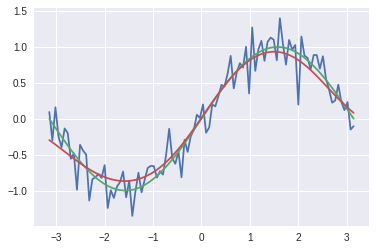

In [407]:
def train(x_train, y_train, minibatch_size):
    
    x = tf.get_default_graph().get_tensor_by_name('x:0')
    y = tf.get_default_graph().get_tensor_by_name('y:0')
        
    forward_pass = compute_forward_pass()

    mse = tf.square(tf.sub(tf.get_default_graph().get_tensor_by_name('y:0'), forward_pass))

    loss = tf.reduce_mean(tf.add(mse, 0.001 * compute_l2_regularization()))

    train_op = tf.train.AdagradOptimizer(0.8).minimize(loss)
    
    saver = tf.train.Saver()

    with tf.Session(graph=tf.get_default_graph()) as session:
        session.run(tf.global_variables_initializer())
        
        n_minibatch = np.int(np.ceil(x_train.shape[0]/np.float(minibatch_size)))
        print('Nr of minibatches: %d' % n_minibatch)
    
        for epoch_ix in range(3000):
            epoch_loss = 0
            for minibatch_ix in range(n_minibatch):
                _, output_loss = session.run([train_op, loss], feed_dict={x: np.matrix(x_train[minibatch_ix*minibatch_size:(minibatch_ix+1)*minibatch_size]).T, y: y_train[minibatch_ix*minibatch_size:(minibatch_ix+1)*minibatch_size]})
                epoch_loss += output_loss

            if (epoch_ix%300) == 0:
                print(epoch_loss, compute_l2_regularization().eval())
        
        w1, b1, w2 = get_variables(reuse=True)
        
        print(w1.eval())
        print(b1.eval())
        print(w2.eval())
        
        saver.save(session, "/tmp/model.ckpt")
        print('Session saved')

    return saver

def predict(x_test, saver):
    x = tf.get_default_graph().get_tensor_by_name('x:0')
    
    predictions = None
    
    with tf.Session(graph=tf.get_default_graph()) as session:
        
#         i dont run the initializer but the session.restore
        saver.restore(session, "/tmp/model.ckpt")
        print("Session restored")
        
        predictions = session.run(compute_forward_pass(), feed_dict={x: np.matrix(x_test).T})
        
        assert predictions is not None
        
        w1, b1, w2 = get_variables(reuse=True)
        
#         now these variables are the same as when training ended!
        print(w1.eval())
        print(b1.eval())
        print(w2.eval())
    
    return predictions


graph_1 = create_graph()

with graph_1.as_default():
    saver = train(x_train, y_train, minibatch_size)
    predictions = predict(x_train, saver)

plt.plot(x_train, y_train)
plt.plot(x_train, y_sin)
plt.plot(x_train, np.array(predictions).reshape((-1,)))
plt.show()

##### A comment on graphs handling
Operations and Tensors are associated to a specific graph. For any computation, the intervening variables must be part of the same graph.

There is a default graph, which is instantiated when the library is imported. Additionally we can create graphs at will by calling `tf.Graph()`. If we create a new graph, it is not assigned as the default graph.

Using the statement `with [graph].as_default()`, we are specifying that the operations within the block are gonna use [graph] as default.

We can retrieve the default graph via `tf.get_default_graph()`.

When calling `tf.reset_default_graph()`, a new graph is created and assigned as default.

Finally, we can query existing tensors in a graph using `print([n.name for n in tf.get_default_graph().as_graph_def().node])`.

See the examples below:

In [278]:
# i create a new graph
my_graph = tf.Graph()
print(my_graph)

# the new graph is not automatically assigned as the default graph.
print(tf.get_default_graph())

# reseting the graph creates a new default graph.
tf.reset_default_graph()
print(tf.get_default_graph())

# when using `[graph].as_default()` we set [graph] as default for that scope
with my_graph.as_default():
    print(my_graph==tf.get_default_graph(), tf.get_default_graph())

True <tensorflow.python.framework.ops.Graph object at 0x7f86bdb38f98>


##### Saving and restoring graphs (and their states)
What we have seen so far was: with an existing graph instance (always the same instance!), creating and closing sessions and saving and retrieving their states. This section deals with the case when we want to use a trained model but we no longer have the corresponding graph instance. In the documentation, this is referred to as "Exporting and Importing a MetaGraph".

A Tensorflow model consists of two main things, which are saved/restored separatedly -also, manually-:
1. _the graph definition: saved and loaded using_ `tf.train.export_meta_graph()` and `tf.train.import_meta_graph()`.
2. _the graph's state (the variables' values)_: saved and restored using `tf.train.Saver().save()` and `tf.train.Saver().restore()`, respectively.

The workflow for saving and restoring models should be:
1. Instantiate collections and append the the graph objects (placeholders, variables, ops) we will later retrieve `tf.add_to_collection('vars', w1)`.
2. Instantiate a Saver `saver = tf.train.Saver()`.
3. Save the session `saver.save(session, '/tmp/model.ckpt')` (by default, this statement will export the MetaGraph).
4. Export the MetaGraph `tf.train.export_meta_graph(filename='/tmp/model.meta')` (if not performed in the previous op).
5. Import the MetaGraph `saver = tf.train.import_meta_graph('/tmp/model.meta')` (this will create a Saver object).
6. Restore the session `saver.restore(session, '/tmp/model.ckpt')`.
7. Retrieve the graph objects (placeholders, variables, ops) from the collection `tf.get_collection('vars')`.

_"The MetaGraph contains the information required to continue training, perform evaluation, or run inference on a previously trained graph."_



In [391]:
graph_1 = tf.Graph()
print('Graph_1 is: ', graph_1)

with graph_1.as_default():
    
    x = tf.placeholder(dtype=tf.int64, name='x')
    
    w1 = tf.Variable(initial_value=tf.random_normal([1,1], stddev=0.2), name='w1')
    w2 = tf.Variable(initial_value=tf.random_normal([1,1], stddev=0.2), name='w2')
    
#     create collections and add objects to them
    tf.add_to_collection('place', x)
    tf.add_to_collection('params', w1)
    tf.add_to_collection('params', w2)

#     instantiate a saver
    saver = tf.train.Saver()

with tf.Session(graph=graph_1) as session:
    session.run(tf.global_variables_initializer())
    print('The default graph is graph_1: %s %s' % (tf.get_default_graph()==graph_1, tf.get_default_graph()))

    print('The value of graph_1 w is: ', w1.eval())
    
#     save the session
    saver.save(session, '/tmp/model.ckpt')
    print('Session saved')

#     save the MetaGraph (this is already done by the previous statement)
    tf.train.export_meta_graph(filename='/tmp/model.meta')
    print('MetaGraph exported')
    

graph_2 = tf.Graph()
print('Graph_2 is: ', graph_2)

with tf.Session(graph=graph_2) as session:
    print('The default graph is graph_2: %s %s' % (tf.get_default_graph()==graph_2, tf.get_default_graph()))
    
#     i restore the MetaGraph (this creates a new saver, i no longer need the previous one!)
    saver = tf.train.import_meta_graph('/tmp/model.meta')
#     i restore the session
    saver.restore(session, '/tmp/model.ckpt')
    
#     note that the default graph continues to be graph_2, not graph_1!
    print('The default graph is graph_2: %s %s' % (tf.get_default_graph()==graph_2, tf.get_default_graph()))

    w1, w2 = tf.get_collection('params')
    
    print(w1.eval())

Graph_1 is:  <tensorflow.python.framework.ops.Graph object at 0x7f86bc3a5fd0>
The default graph is graph_1: True <tensorflow.python.framework.ops.Graph object at 0x7f86bc3a5fd0>
The value of graph_1 w is:  [[ 0.10279728]]
Session saved
MetaGraph exported
Graph_2 is:  <tensorflow.python.framework.ops.Graph object at 0x7f86bdbbc2b0>
The default graph is graph_2: True <tensorflow.python.framework.ops.Graph object at 0x7f86bdbbc2b0>
The default graph is graph_2: True <tensorflow.python.framework.ops.Graph object at 0x7f86bdbbc2b0>
[[ 0.10279728]]


#### Also
Learning visualizations: https://www.tensorflow.org/get_started/summaries_and_tensorboard
        
Embedding visualisations: https://www.tensorflow.org/get_started/embedding_viz

## Seeding
There is no such thing as seeding at module/Tensorflow-level. Operations that run random statements can be seeded either at: (1) operation level; or (2) graph level.

This is done by calling `tf.set_random_seed(value)`.

**Note** that this must be done for each graph! And if no graph is specified, as always, it will impact the default graph. See below:

#### The wrong way (common mistake)

In [396]:
# instantiate a graph
graph_1 = tf.Graph()

# this way im seeding the default graph
tf.set_random_seed(1234)

with graph_1.as_default():
#     define a random var
    x = tf.random_normal([1,1], stddev=0.2)

with tf.Session(graph=graph_1) as session:
    session.run(tf.global_variables_initializer())
    print(x.eval())

with tf.Session(graph=graph_1) as session:
    session.run(tf.global_variables_initializer())
    print(x.eval())
    
# Result: there is no seed for graph_1

[[ 0.05492095]]
[[ 0.03341978]]


#### The right way

In [398]:
# instantiate a graph
graph_1 = tf.Graph()

with graph_1.as_default():
#     this way im seeding graph_1
    tf.set_random_seed(1234)

with graph_1.as_default():
#     define a random var
    x = tf.random_normal([1,1], stddev=0.2)

with tf.Session(graph=graph_1) as session:
    session.run(tf.global_variables_initializer())
    print(x.eval())

with tf.Session(graph=graph_1) as session:
    session.run(tf.global_variables_initializer())
    print(x.eval())
    
# Result: graph_1 is properly seeded!

[[-0.02772504]]
[[-0.02772504]]
